# Doing simple analysis of songs with the help of basic skills that i've gained in the past year

In [1]:
import os
import sqlite3
from mutagen.easyid3 import EasyID3
from mutagen.mp4 import MP4
from mutagen.flac import FLAC
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Function to get the artist and song name from audio file metadata
def get_metadata(file_path):
    _, ext = os.path.splitext(file_path)
    if ext.lower() == ".mp3":
        audio = EasyID3(file_path)
        artist = audio["artist"][0] if "artist" in audio else "Unknown Artist"
        title = audio["title"][0] if "title" in audio else "Unknown Title"
        genre = audio["genre"][0] if "genre" in audio else "Unknown Genre"
        year = audio["date"][0].split("-")[0] if "date" in audio else "Unknown Year"
    elif ext.lower() == ".m4a":
        audio = MP4(file_path)
        artist = audio["\xa9ART"][0] if "\xa9ART" in audio else "Unknown Artist"
        title = audio["\xa9nam"][0] if "\xa9nam" in audio else "Unknown Title"
        genre = audio["\xa9gen"][0] if "\xa9gen" in audio else "Unknown Genre"
        year = audio["\xa9day"][0].split("-")[0] if "\xa9day" in audio else "Unknown Year"

    elif ext.lower() == ".flac":
        audio = FLAC(file_path)
        artist = audio["artist"][0] if "artist" in audio else "Unknown Artist"
        title = audio["title"][0] if "title" in audio else "Unknown Title"
        genre = audio["genre"][0] if "genre" in audio else "Unknown Genre"
        year = audio["date"][0].split("-")[0] if "date" in audio else "Unknown Year"
    else:
        return None, None, None, None

    return artist, title, genre, year
def process_audio_files(folder_path, database_path):
    # Connect to the SQLite database
    conn = sqlite3.connect(database_path)
    cursor = conn.cursor()
    
    cursor.executescript('''DROP TABLE IF EXISTS songs''')

    cursor.executescript('''
     CREATE TABLE IF NOT EXISTS songs (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            artist TEXT,
            title TEXT,
            genre TEXT,
            year INTEGER
        )
    ''')

    # Loop through the files in the folder and process each audio file
    for root, _, files in os.walk(folder_path):
        for file_name in files:
            file_path = os.path.join(root, file_name)
            artist, title, genre, year = get_metadata(file_path)
            if artist and title:
                # Insert the extracted metadata into the database
                cursor.execute('INSERT INTO songs (artist, title, genre, year) VALUES (?, ?, ?, ?)', (artist, title, genre, year))
    # Commit the changes and close the database connection
    conn.commit()
    conn.close()

if __name__ == "__main__":
    folder_path = "D:\Music\mp3"
    database_path = "songs.sqlite"

    process_audio_files(folder_path, database_path)


In [3]:
def read_db(database_path):
    conn = sqlite3.connect("songs.sqlite") # Connect to the SQLite database

    query = "SELECT * FROM songs"  # Query to fetch all rows from the 'songs' table

    df = pd.read_sql_query(query, conn)  # Read the data into a DataFrame using pandas

    conn.close() # Close the database connection

    return df

# Path to your SQLite database file
db_path = "songs.sqlite"

# Call the function to read the data into a Pandas DataFrame
df_songs = read_db(db_path)

# Display the DataFrame
df_songs.head()

,id,artist,title,genre,year
0,1,The Weeknd,Alone Again,R&B,2020
1,2,Official髭男dism,Cry Baby,Anime,2021
2,3,"Clean Bandit, Zara Larsson",Symphony (feat. Zara Larsson),Electro,2018
3,4,Nick Jonas,Voodoo,pop,Unknown Year
4,5,米津玄師,馬と鹿,JPop,2019


In [4]:
df_songs.set_index(['id'], inplace=True)
df_songs.head()

,artist,title,genre,year
id,,,,
1,The Weeknd,Alone Again,R&B,2020
2,Official髭男dism,Cry Baby,Anime,2021
3,"Clean Bandit, Zara Larsson",Symphony (feat. Zara Larsson),Electro,2018
4,Nick Jonas,Voodoo,pop,Unknown Year
5,米津玄師,馬と鹿,JPop,2019


In [5]:
df_songs.describe()

,artist,title,genre,year
count,497,497,497,497
unique,293,483,47,42
top,Eminem,Lemon,Pop,2019
freq,28,3,106,64


1. According to the above table it is clearly shown that Eminem rules my playlist (as well as my heart since 2013)

### Plotting a Bar Chart to track most songs sort by artist for top 15 artist in the playlist

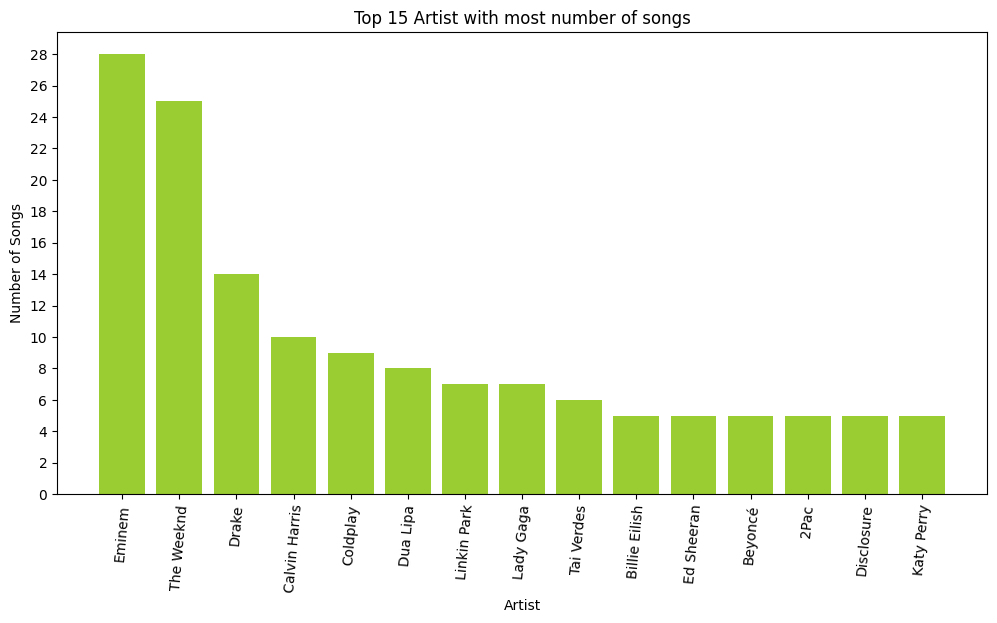

In [6]:
#selecting the top 15 artists
artist_counts = df_songs['artist'].value_counts().nlargest(15)

# plotting the bar graph
plt.figure(figsize=(12,6), edgecolor='red')
plt.bar(artist_counts.index, artist_counts.values, color ='yellowgreen')

plt.xticks(rotation=85)
plt.yticks(range(0,artist_counts.max()+2, 2))

plt.xlabel('Artist')
plt.ylabel('Number of Songs')
plt.title('Top 15 Artist with most number of songs')

plt.show()

1. Undoubtably the most songs are by Emienm
2. I had thought that Drake might be the artist with second most songs in the playlist but its The Weeknd because i have some songs by the weeknd just sitting in the playlist even though i rarely listen to them

### Now lets plot a stackplot to get which genre songs are packed in my playlist

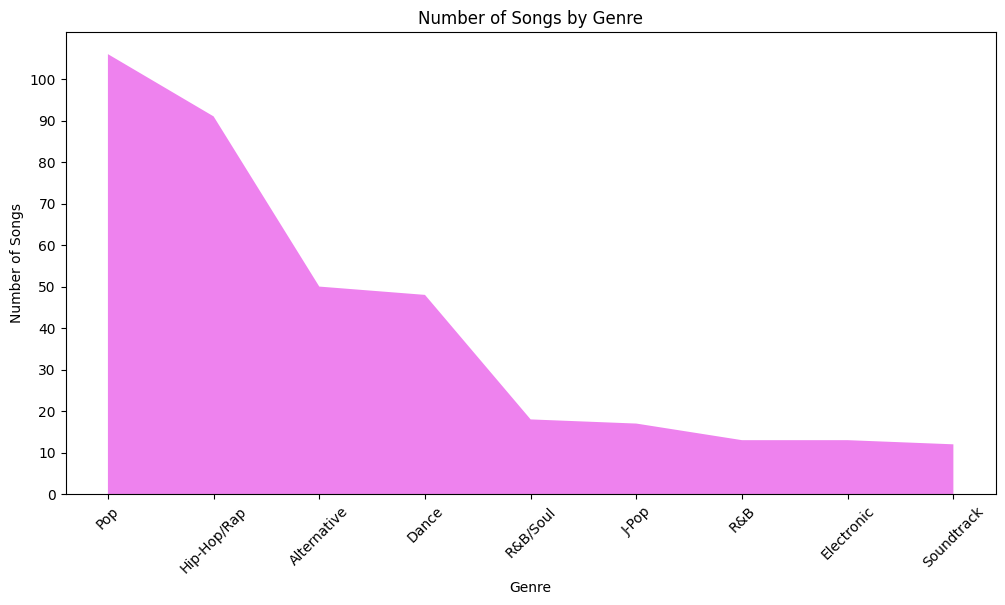

In [7]:
Genre_counts = df_songs['genre'].value_counts().nlargest(10).drop('Unknown Genre')

# plotting the stackplot
colors = ['violet']
plt.figure(figsize=(12,6))
plt.stackplot(Genre_counts.index, Genre_counts.values, colors=colors)

plt.xticks(rotation=45)
plt.yticks(range(0,Genre_counts.max()+2, 10))

plt.xlabel('Genre')
plt.ylabel('Number of Songs')
plt.title('Number of Songs by Genre')

plt.show()

1. surprisingly Pop is the genre according have most songs in the playlist but nowdays I oftern find myself listening to Rock or Hip-Hop
2. so i would say my love for Hip-Hop, Rock\Metal\Alternative is much more than Pop

#### Note
##### Until creating the dataframe the code is partially generated with the help of GPT 3.5